### Fit logistic regression to responses against predictors for selected sample grids

#### Data used

- Predictands: gridded precipitation data (AGCD v1), gridded evapotranspiration and runoff data (AWRA)
- Predictors: season, climate drivers (ENSO, IOD, and SAM, these could be categorical or quantitative)

#### Code fits the model to data at various time scales and thresholds using xarray parallel functionality for gridded datasets

In [1]:
%who

Interactive namespace is empty.


In [ ]:
import sys
new_path = '/home/566/ad9701/drought_probability/'
if new_path not in sys.path:
    sys.path.append(new_path)

import xarray as xr
import numpy as np
import pandas as pd
import my_glmfit_funcs as my
import climtas.io

main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

varname = 'PminusE' #'P'   # the name of the directory and file
vname = 'PminusE' #'precip'  # the name of the variable inside the files
fname = varname + '_*_SEA_*.nc'

# select thresholds
threshList = np.append(np.array(20), np.arange(50, 350, 50))

# select timescales for analysis
ts = [2, 6, 8, 12]

# get the sst predictors
sst_dir = '/g/data/w97/ad9701/p_prob_analysis/sst_data/'
pNames = ['soi', 'sami', 'dmi', 'nino34_anom', 'nino4_anom']
pFiles = ['soi_monthly.nc', 'newsam.1957.2021.nc', 'dmi.had.long.data.nc', 'nino34.long.anom.data.nc', 'nino4.long.anom.data.nc']
for p in np.arange(len(pNames)):
    ds_temp = xr.open_dataset(sst_dir+pFiles[p])
    if (p>0):
        ds_p[pNames[p]]=ds_temp[pNames[p]]
    else:
        ds_p = ds_temp
    del ds_temp

# select the predictors to include in the model
predSel = ['season', 'soi', 'dmi']
formula = 'response ~ C(season)+soi+dmi'
parameter = ['Intercept', 'C(season)[T.JJA]', 'C(season)[T.MAM]', 'C(season)[T.SON]']
parameter.extend(predSel[1:])
    
# create a new df of sample points at which 'predictions' will be made using the fitted model
time_slice = slice('1911-01-01','2020-05-31')
ds_p_subset = ds_p.sel(time = time_slice)
pred_dict = {}
for p in pNames:
    pred_dict.update({p: ds_p_subset[p].values})
pred_dict.update({"season": ds_p_subset['time.season'].values})    # add season to the sst predictors    
pred_df = pd.DataFrame(pred_dict, index = ds_p_subset['time'])     # make a dataframe of predictors
pred_df_sel = pred_df[predSel]
x_new = my.createSampleDf(pred_df_sel, list(pred_df_sel.keys()))

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

# from dask.distributed import Client,Scheduler
# from dask_jobqueue import SLURMCluster
# cluster = SLURMCluster(cores=16,memory="31GB")
# client = Client(cluster)
# cluster.scale(cores=32)
# client

for iW in ts:
    # get data
    data_dir = main_dir + varname + '_week' + str(iW) + '/'
    ds = xr.open_mfdataset(data_dir + fname, chunks = {'lat':400, 'lon':400})
    da_var = ds[vname].chunk(chunks = {'lat':40,'lon':40,'time':-1})
    
    # select predictors for the same time points as the P-E or P-E-Q data
    da_time_bymon = np.array(pd.to_datetime(ds.time).to_period('M').to_timestamp().floor('D'))
    ds_p_sel = ds_p.sel(time = da_time_bymon)
    x_dict = {}
    for p in pNames:
        x_dict.update({p:ds_p_sel[p].values})
    x_dict.update({"season": ds['time.season'].values})     # add season to the sst predictors    
    x_df = pd.DataFrame(x_dict, index = ds_p_sel['time'])   # make a dataframe of predictors
    
    # apply the ufunc to fit logistic regression
    dask_gufunc_kwargs = {'output_sizes':{"parameter": 6, "sample":len(x_new)}}
    da_logistReg = xr.apply_ufunc(
        my.fit_logistReg_3Pred,                      # first the function, this function returns a tuple (GLM params, GLM pvalues, GLM modelled probabilities)
        da_var,                                      # function arg
        [str(i) for i in x_df[predSel[0]].values],   # function arg
        x_df[predSel[1]].values,                     # function arg
        x_df[predSel[2]].values,                     #      "
        predSel,                                     #      "
        threshList,                                  #      "
        formula,                                     #      "
        [str(i) for i in x_new[predSel[0]].values],  #      "
        x_new[predSel[1]].values,                    #      "
        x_new[predSel[2]].values,                    #      "
        input_core_dims=[["time"], ["time"], ["time"], ["time"], ["predictors"], ["threshold"], [], ["sample"], ["sample"], ["sample"]],   # list with one entry per arg, these are the dimensions not to be broadcast
        output_core_dims=[["parameter", "threshold"], ["parameter", "threshold"], ["sample", "threshold"]],                                # dimensions of the output
        vectorize=True,                                                                                                                    # broadcast over non-core dimensions of the input object?
        dask="parallelized",                                                                                                               # enable dask?
        dask_gufunc_kwargs=dask_gufunc_kwargs,                     
        output_dtypes=[float, float, float]
    )
    
    # assign co-ordinates add metadata
    new_coords_dict = {'threshold':threshList, 'parameter':parameter}
    da_params = da_logistReg[0].rename('glm_params').assign_coords(new_coords_dict)
    da_pvalues = da_logistReg[1].rename('glm_pvalues').assign_coords(new_coords_dict)
    ds_prob = da_logistReg[2].rename('glm_probability').assign_coords({'threshold':threshList}).to_dataset()
    for k in list(x_new.keys()):
        ds_prob[k] = x_new[k]
    ds_prob = ds_prob.rename({'dim_0':'sample'})


    # save file
    out_file = data_dir + 'GLM_params_' + '_'.join(predSel) + '.nc'
    climtas.io.to_netcdf_throttled(da_params, out_file)
    out_file = data_dir + 'GLM_pvalues_' + '_'.join(predSel) + '.nc'
    climtas.io.to_netcdf_throttled(da_pvalues, out_file)
    out_file = data_dir + 'GLM_probability_' + '_'.join(predSel) + '.nc'
    climtas.io.to_netcdf_throttled(ds_prob, out_file)
    
cluster.scale(cores=0)
client
! squeue -u ad9701

  0%|          | 0/28 [00:00<?, ?it/s]

distributed.worker - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 2.31 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 1.68 GiB -- Worker memory limit: 2.81 GiB


  0%|          | 0/28 [00:00<?, ?it/s]

distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 2.28 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 1.67 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.26 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 1.64 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 2.34 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 1.67 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 2.34 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is 

  0%|          | 0/28 [00:00<?, ?it/s]

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.73 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.79 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.79 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

  0%|          | 0/28 [00:00<?, ?it/s]

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.89 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.99 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.99 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

  0%|          | 0/28 [00:00<?, ?it/s]

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.89 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.80 GiB -- Worker memory limit: 2.81 GiB


In [2]:
cluster.scale(cores=0)

In [2]:
client

<Client: 'tcp://10.0.128.145:37941' processes=8 threads=32, memory=57.76 GiB>

In [3]:
! squeue -u ad9701

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              6200       vdi sys/dash   ad9701  R       3:37      1 ood-vn19


In [42]:
new_coords_dict['threshold']

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [31]:
x_new.keys()

Index(['season', 'soi', 'dmi'], dtype='object')

In [17]:
parameter = ['Intercept', 'C(season)[T.JJA]', 'C(season)[T.MAM]', 'C(season)[T.SON]']
parameter.extend(predSel[1:])
parameter

['Intercept',
 'C(season)[T.JJA]',
 'C(season)[T.MAM]',
 'C(season)[T.SON]',
 'soi',
 'dmi']

In [14]:
['Intercept', 'C(season)[T.JJA]', 'C(season)[T.MAM]', 'C(season)[T.SON]'].append(predSel[1:])

In [45]:
del ds_subset
lat_slice = slice(-36.3, -36.2) #tiny slice for testing
lon_slice = slice(148.9, 149)
ds_subset = ds[vname].sel(lat = lat_slice, lon = lon_slice).chunk(chunks = {'lat':40,'lon':40,'time':-1})
#ds_subset.load()

In [25]:
# calculate exceedence probabilities for selected thresholds

dask_gufunc_kwargs = {'output_sizes':{"parameter": 6}}

da_logistReg = xr.apply_ufunc(
    fit_logistReg,                             # first the function
    ds_subset,                                 # function arg
    [str(i) for i in x_df[predSel[0]].values],
    #x_df[predSel[0]].values,
    x_df[predSel[1]].values,
    x_df[predSel[2]].values,
    predSel,
    threshList[0],
    formula,
    input_core_dims=[["time"], ["time"], ["time"], ["time"], ["predictors"], [], []],  # list with one entry per arg
    output_core_dims=[["parameter"], ["parameter"]],           # dimensions of the output
    vectorize=True,                             # broadcast over non-core dimensions of the input object?
    dask="parallelized",                        # enable dask?
    dask_gufunc_kwargs=dask_gufunc_kwargs,
    output_dtypes=[float, float]
)
da_logistReg

(<xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6)>
 dask.array<transpose, shape=(3, 2, 6), dtype=float64, chunksize=(3, 2, 6), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: parameter,
 <xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6)>
 dask.array<transpose, shape=(3, 2, 6), dtype=float64, chunksize=(3, 2, 6), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: parameter)

In [36]:
dask_gufunc_kwargs = {'output_sizes':{"parameter": 6, "sample":len(x_new)}}

da_logistReg = xr.apply_ufunc(
    fit_logistReg_3Pred,                             # first the function
    ds_subset,                                 # function arg
    [str(i) for i in x_df[predSel[0]].values],
    x_df[predSel[1]].values,
    x_df[predSel[2]].values,
    predSel,
    threshList[0],
    formula,
    [str(i) for i in x_new[predSel[0]].values],
    x_new[predSel[1]].values,
    x_new[predSel[2]].values,
    input_core_dims=[["time"], ["time"], ["time"], ["time"], ["predictors"], [], [], ["sample"], ["sample"], ["sample"]],  # list with one entry per arg
    output_core_dims=[["parameter"], ["parameter"], ["sample"]],           # dimensions of the output
    vectorize=True,                             # broadcast over non-core dimensions of the input object?
    dask="parallelized",                        # enable dask?
    dask_gufunc_kwargs=dask_gufunc_kwargs,
    output_dtypes=[float, float, float]
)
da_logistReg

(<xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6)>
 dask.array<transpose, shape=(3, 2, 6), dtype=float64, chunksize=(3, 2, 6), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: parameter,
 <xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6)>
 dask.array<transpose, shape=(3, 2, 6), dtype=float64, chunksize=(3, 2, 6), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: parameter,
 <xarray.DataArray 'PminusE' (lat: 3, lon: 2, sample: 36)>
 dask.array<transpose, shape=(3, 2, 36), dtype=float64, chunksize=(3, 2, 36), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: sample)

In [46]:
dask_gufunc_kwargs = {'output_sizes':{"parameter": 6, "sample":len(x_new)}}

da_logistReg = xr.apply_ufunc(
    fit_logistReg_3Pred,                             # first the function
    ds_subset,                                 # function arg
    [str(i) for i in x_df[predSel[0]].values],
    x_df[predSel[1]].values,
    x_df[predSel[2]].values,
    predSel,
    threshList,
    formula,
    [str(i) for i in x_new[predSel[0]].values],
    x_new[predSel[1]].values,
    x_new[predSel[2]].values,
    input_core_dims=[["time"], ["time"], ["time"], ["time"], ["predictors"], ["threshold"], [], ["sample"], ["sample"], ["sample"]],  # list with one entry per arg
    output_core_dims=[["parameter", "threshold"], ["parameter", "threshold"], ["sample", "threshold"]],           # dimensions of the output
    vectorize=True,                             # broadcast over non-core dimensions of the input object?
    dask="parallelized",                        # enable dask?
    dask_gufunc_kwargs=dask_gufunc_kwargs,
    output_dtypes=[float, float, float]
)
da_logistReg

(<xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6, threshold: 3)>
 dask.array<transpose, shape=(3, 2, 6, 3), dtype=float64, chunksize=(3, 2, 6, 3), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: parameter, threshold,
 <xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6, threshold: 3)>
 dask.array<transpose, shape=(3, 2, 6, 3), dtype=float64, chunksize=(3, 2, 6, 3), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: parameter, threshold,
 <xarray.DataArray 'PminusE' (lat: 3, lon: 2, sample: 36, threshold: 3)>
 dask.array<transpose, shape=(3, 2, 36, 3), dtype=float64, chunksize=(3, 2, 36, 3), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 -36.3 -36.25 -36.2
   * lon      (lon) float32 148.9 149.0
 Dimensions without coordinates: sample, 

(array([16., 34., 28., 16., 20., 25., 27., 23., 20.,  7.]),
 array([0.02056362, 0.02401147, 0.02745933, 0.03090718, 0.03435504,
        0.03780289, 0.04125075, 0.0446986 , 0.04814646, 0.05159431,
        0.05504217]),
 <BarContainer object of 10 artists>)

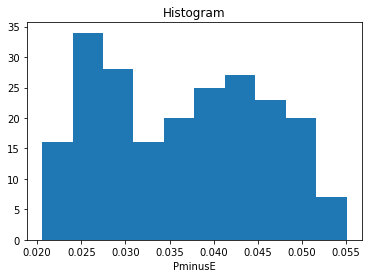

In [40]:
da_logistReg[2].plot()

In [30]:
display(da_logistReg[1])

<xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6)>
dask.array<transpose, shape=(3, 2, 6), dtype=float64, chunksize=(3, 2, 6), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -36.3 -36.25 -36.2
  * lon      (lon) float32 148.9 149.0
Dimensions without coordinates: parameter

In [18]:
display(da_logistReg[0])

<xarray.DataArray 'PminusE' (lat: 3, lon: 2, parameter: 6)>
array([[[-3.10617271, -0.58980553, -0.0167582 , -0.53712667,
          0.0056942 , -0.29715044],
        [-3.07974217, -0.37122422, -0.01415651, -0.52134133,
          0.0089666 , -0.33374076]],

       [[-3.08058104, -0.37026029, -0.01351029, -0.52072104,
          0.00975263, -0.32974397],
        [-3.06735506, -0.66739623, -0.0471972 , -0.55389457,
          0.00880372, -0.1573553 ]],

       [[-3.10900579, -0.42475159,  0.01994533, -0.33490167,
          0.00981782, -0.26115424],
        [-3.10341827, -0.51632982,  0.05368956, -0.27680045,
          0.01132131, -0.14135533]]])
Coordinates:
  * lat      (lat) float32 -36.3 -36.25 -36.2
  * lon      (lon) float32 148.9 149.0
Dimensions without coordinates: parameter

In [12]:
x_df

,soi,sami,dmi,nino34_anom,nino4_anom,season
1911-01-01,3.2,NaN,-0.129,-0.57,-0.64,DJF
1911-01-01,3.2,NaN,-0.129,-0.57,-0.64,DJF
1911-01-01,3.2,NaN,-0.129,-0.57,-0.64,DJF
1911-02-01,1.6,NaN,-0.406,-0.58,-0.47,DJF
1911-02-01,1.6,NaN,-0.406,-0.58,-0.47,DJF
...,...,...,...,...,...,...
2020-03-01,-5.2,2.05,0.119,0.36,0.70,MAM
2020-03-01,-5.2,2.05,0.119,0.36,0.70,MAM
2020-04-01,-0.5,-1.72,0.064,0.49,0.61,MAM
2020-04-01,-0.5,-1.72,0.064,0.49,0.61,MAM


In [129]:
ds_subset

<xarray.DataArray 'PminusE' (time: 2854, lat: 3, lon: 2)>
array([[[ 45.97025974,  44.29841697],
        [ 46.366253  ,  45.18223064],
        [ 49.68591145,  47.23815196]],

       [[ 32.04177396,  33.45695541],
        [ 33.47816961,  33.19218539],
        [ 37.2508357 ,  37.44396204]],

       [[-27.60605307, -27.10445331],
        [-24.2750939 , -22.79340897],
        [-16.67595264, -15.85017451]],

       ...,

       [[ -8.58921829,  -8.19655639],
        [ -9.25613655,  -7.89669535],
        [ -8.51502691,  -8.42996135]],

       [[  0.58857981,   0.44023026],
        [  2.40148296,   1.98362266],
        [  5.32876055,   3.83014456]],

       [[ -2.96836607,  -2.56080789],
        [ -3.29420228,  -2.60574758],
        [ -3.44360644,  -3.24858353]]])
Coordinates:
  * lat      (lat) float32 -36.3 -36.25 -36.2
  * time     (time) datetime64[ns] 1911-01-02 1911-01-16 ... 2020-05-11
  * lon      (lon) float32 148.9 149.0

In [44]:
x_temp = pd.DataFrame.to_xarray(x_df[predSel])
#x_temp['season']
x_temp

<xarray.Dataset>
Dimensions:  (index: 2854)
Coordinates:
  * index    (index) datetime64[ns] 1911-01-01 1911-01-01 ... 2020-05-01
Data variables:
    season   (index) object 'DJF' 'DJF' 'DJF' 'DJF' ... 'MAM' 'MAM' 'MAM' 'MAM'
    soi      (index) float64 3.2 3.2 3.2 1.6 1.6 3.5 ... -5.2 -5.2 -0.5 -0.5 2.8
    dmi      (index) float64 -0.129 -0.129 -0.129 -0.406 ... 0.064 0.064 0.378

In [51]:
GLM_test = fit_logistReg(da_pt.values, x_df, threshList, formula, x_new)
GLM_test

(array([[-3.32128575e+00, -5.08859565e+00,             nan],
        [ 3.06182084e-01, -1.75891911e+00,             nan],
        [ 7.28857292e-03, -1.76688738e+00,             nan],
        [-5.55344893e-01, -1.77439481e+00,             nan],
        [ 3.61260840e-02,  7.80367710e-02,             nan],
        [-2.36192485e-01, -9.66632009e-04,             nan]]),
 array([[1.88458508e-61, 4.44361054e-25,            nan],
        [2.45946710e-01, 1.09129445e-01,            nan],
        [9.79102750e-01, 1.02642712e-01,            nan],
        [8.71056917e-02, 1.09216704e-01,            nan],
        [4.18179365e-04, 2.81019209e-02,            nan],
        [4.59713909e-01, 9.99358143e-01,            nan]]),
 array([[0.03546393, 0.00609754, 0.        ],
        [0.03284093, 0.00609557, 0.        ],
        [0.03828814, 0.00609951, 0.        ],
        [0.05027555, 0.01330217, 0.        ],
        [0.04660998, 0.0132979 , 0.        ],
        [0.054213  , 0.01330645, 0.        ],
      

In [48]:
y = da_pt.values
x = x_df
thres = threshList
n_predictors = 6

GLM_params = np.empty((n_predictors, len(thres))) # array([])
GLM_pvalues = np.empty((n_predictors, len(thres)))
GLM_probability = np.empty((len(x_new), len(thres)))
for ith in np.arange(len(thres)):
    # create a dataframe of reponse and predictors
    y_binary = np.where(y >= thres[ith], 1, 0)
    x['response'] = y_binary

    if (sum(y_binary) < 4):                      # too few data points for estimation
        GLM_probability[:, ith] = 0
        GLM_params[:, ith] = np.nan
        GLM_pvalues[:, ith] = np.nan   
    else:                                        # logistic regression fit
        model = glm(formula, x, family=sm.families.Binomial())
        model_GLM = model.fit()
        probability = model_GLM.predict(x_new)

        # save the results
        GLM_params[:, ith] = np.array(model_GLM.params.values)
        GLM_pvalues[:, ith] = np.array(model_GLM.pvalues.values)
        GLM_probability[:, ith] = probability

/local/zv2/ad9701/tmp/ipykernel_187403/2524868911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['response'] = y_binary
/local/zv2/ad9701/tmp/ipykernel_187403/2524868911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['response'] = y_binary
/local/zv2/ad9701/tmp/ipykernel_187403/2524868911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [80]:
y = da_pt.values
x = x_df[predSel]
thres = threshList[0]

x_temp = x.copy()
# create a dataframe of reponse and predictors
y_binary = np.where(y >= thres, 1, 0)
x_temp['response'] = y_binary

if (sum(y_binary) < 4):                      # too few data points for estimation
    GLM_probability = 0
    GLM_params = np.nan
    GLM_pvalues = np.nan   
else:                                        # logistic regression fit
    model = glm(formula, x_temp, family=sm.families.Binomial())
    model_GLM = model.fit()
    GLM_probability = model_GLM.predict(x_new)
    GLM_params = model_GLM.params.values
    GLM_pvalues = model_GLM.pvalues.values

In [13]:
y = da_pt.values
x1 = x_df[predSel[0]].values
x2 = x_df[predSel[1]].values
x3 = x_df[predSel[2]].values
thres = threshList[0]
predictors = predSel

x_dict = {predictors[0]:x1, predictors[1]:x2, predictors[2]:x3}
x = pd.DataFrame(x_dict)
#x_new = pd.DataFrame([x1_new, x2_new, x3_new], predictors)
# create a dataframe of reponse and predictors
y_binary = np.where(y >= thres, 1, 0)
x['response'] = y_binary

if (sum(y_binary) < 4):                      # too few data points for estimation
    #GLM_probability = 0
    GLM_params = np.nan
    GLM_pvalues = np.nan   
else:                                        # logistic regression fit
    model = glm(formula, x, family=sm.families.Binomial())
    model_GLM = model.fit()
    #GLM_probability = model_GLM.predict(x_new)
    GLM_params = model_GLM.params.values
    GLM_pvalues = model_GLM.pvalues.values

GLM_params

(array([-3.32128575,  0.30618208,  0.00728857, -0.55534489,  0.03612608,
        -0.23619248]),
 array([1.88458508e-61, 2.45946710e-01, 9.79102750e-01, 8.71056917e-02,
        4.18179365e-04, 4.59713909e-01]))

In [15]:
fit_logistReg(da_pt.values, x_df[predSel[0]].values, x_df[predSel[1]].values, x_df[predSel[2]].values, predSel, threshList[0], formula)

(array([-3.32128575,  0.30618208,  0.00728857, -0.55534489,  0.03612608,
        -0.23619248]),
 array([1.88458508e-61, 2.45946710e-01, 9.79102750e-01, 8.71056917e-02,
        4.18179365e-04, 4.59713909e-01]))

In [11]:
dict(zip([x1, x2, x3], predictors))

TypeError: unhashable type: 'numpy.ndarray'

In [6]:
x1.values

array(['DJF', 'DJF', 'DJF', ..., 'MAM', 'MAM', 'MAM'], dtype=object)

In [33]:
### save dataframes for plotting script
import pickle
# df.to_pickle(file_name)

file_pvalues = out_dir + 'lgR_pvalues.pkl'
file_params = out_dir + 'lgR_params.pkl'
file_pred = out_dir + 'lgR_pred.pkl'

import os, errno

def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occurred
            
silentremove(file_pvalues)
silentremove(file_params)
silentremove(file_pred)

with open(file_pvalues, 'wb') as f:
    pickle.dump(lgR_pvalues_list, f)

with open(file_params, 'wb') as f:
    pickle.dump(lgR_params_list, f)
    
with open(file_pred, 'wb') as f:
    pickle.dump(lgR_pred_list, f)